In [1]:
import numpy as np

from definitions import *
from trainTestValSplit import getTrainTestValSplit
from preProcessing import preProcess

from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
train_concat, test_concat, val_concat = getTrainTestValSplit(
    _dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/Processed_outliers_with_labels'
)

/Volumes/SEAGATE/code/ML4QS-Assignment3/dataset/ExtraSensory/Processed_outliers_with_labels/098A72A5-E3E5-4F54-A152-BBDA0DF7B694.csv


In [3]:
train_x, train_y = preProcess(train_concat)
test_x, test_y = preProcess(test_concat)
val_x, val_y = preProcess(val_concat)

columns = train_x.columns
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)
val_x = val_x.fillna(0)

n_columns = len(columns)
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()
#
# from sklearn.decomposition import PCA
# pca = PCA(n_components=50)
#
# train_x = pca.fit_transform(train_x, train_y)
# test_x = pca.fit_transform(test_x, test_y)
# val_x = pca.fit_transform(val_x, val_y)

In [4]:
n_features: int = n_columns

In [5]:
train_y = encodeTarget(train_y)
test_y = encodeTarget(test_y)
val_y = encodeTarget(val_y)

In [6]:
train_x = reshape_and_truncate(train_x, (-1, window_size, n_features))
train_y = reshape_and_truncate(train_y, (-1, window_size, len(main_activity_label_classes)))

test_x = reshape_and_truncate(test_x, (-1, window_size, n_features))
test_y = reshape_and_truncate(test_y, (-1, window_size, len(main_activity_label_classes)))

val_x = reshape_and_truncate(val_x, (-1, window_size, n_features))
val_y = reshape_and_truncate(val_y, (-1, window_size, len(main_activity_label_classes)))

In [7]:
with tf.device('/cpu:0'):
    model = tf.keras.Sequential()

    layer = tf.keras.layers.Normalization(axis=-1)
    layer.adapt(train_x)
    model.add(layer)
    model.add(tf.keras.layers.LSTM(100, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(n_y, activation=tf.keras.activations.softmax))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=
    tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
    ), metrics=['acc'])
    history = model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size,
                        callbacks=[
                            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience,
                                                             mode='auto', restore_best_weights=True)])
    predict = model.predict(test_x)

Metal device set to: Apple M1 Pro


2022-06-25 20:45:07.080021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-25 20:45:07.080170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-25 20:45:07.104211: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
650/650 [==============================] - 7s 9ms/step - loss: 1.5743 - acc: 0.5378 - val_loss: 1.3203 - val_acc: 0.6578
Epoch 2/100
650/650 [==============================] - 5s 8ms/step - loss: 1.1259 - acc: 0.6925 - val_loss: 1.0820 - val_acc: 0.7147
Epoch 3/100
650/650 [==============================] - 5s 7ms/step - loss: 0.9963 - acc: 0.7155 - val_loss: 1.0123 - val_acc: 0.7169
Epoch 4/100
650/650 [==============================] - 6s 9ms/step - loss: 0.9303 - acc: 0.7243 - val_loss: 0.9658 - val_acc: 0.7198
Epoch 5/100
650/650 [==============================] - 7s 10ms/step - loss: 0.8823 - acc: 0.7312 - val_loss: 0.9289 - val_acc: 0.7213
Epoch 6/100
650/650 [==============================] - 6s 10ms/step - loss: 0.8416 - acc: 0.7386 - val_loss: 0.8990 - val_acc: 0.7240
Epoch 7/100
650/650 [==============================] - 6s 10ms/step - loss: 0.8070 - acc: 0.7459 - val_loss: 0.8772 - val_acc: 0.7236
Epoch 8/100
650/650 [==============================] - 7s 10ms/ste

In [8]:
# gold_labels = np.load('gold.txt.npy')
# predicted_labels = np.load('pred.txt.npy')
gold_labels = get_labels(test_y)
predicted_labels = get_labels(predict)

In [9]:
print(f'F1: {f1_score(gold_labels, predicted_labels, average="weighted")}')
print(f'Precision: {precision_score(gold_labels, predicted_labels, average="weighted", zero_division=0)}')
print(f'Recall: {recall_score(gold_labels, predicted_labels, average="weighted", zero_division=0)}')
# F1: 0.7524208164862666
# Precision: 0.7564173218179143
# Recall: 0.7772232304900182

F1: 0.7555540653471055
Precision: 0.7552880585113908
Recall: 0.7758620689655172


In [10]:
tf.math.confusion_matrix(gold_labels, predicted_labels)

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[1121,   24,  101,    7,    2,    0,    1],
       [   6, 1639,  168,    2,    2,    0,    0],
       [  19,  202, 2072,   82,   89,    0,   21],
       [  10,   75,  442,   85,   43,    0,   12],
       [   4,    5,  106,   19,  169,    0,    4],
       [   0,    0,    1,    8,    0,    0,    0],
       [   5,    0,   18,    2,    2,    0,   44]], dtype=int32)>

n_classes_conf_matrix: 6612


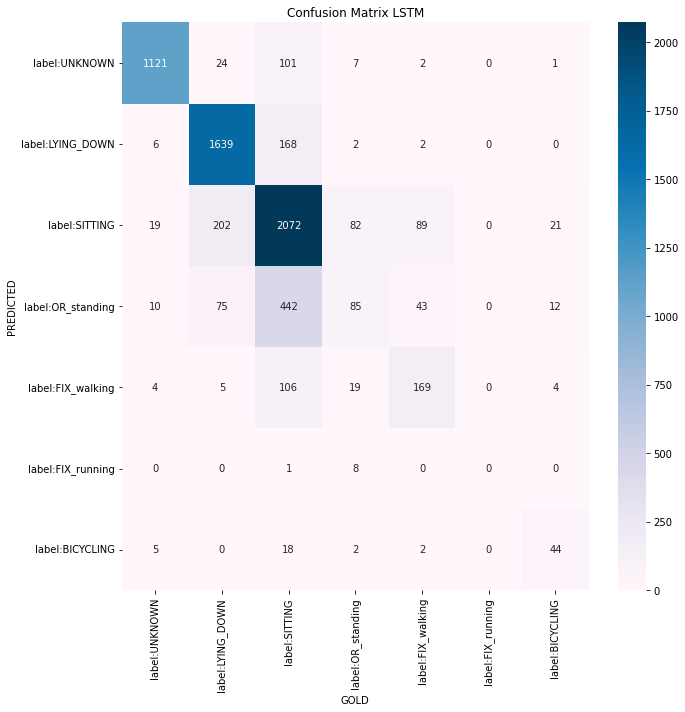

In [11]:
plot_conf_matrix(gold_labels, predicted_labels)

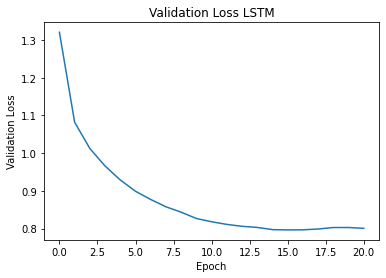

In [12]:
plot_val_loss_progress(history)